# Transfer Learning

In [41]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import time
import copy
import torchsummary

## Loading Data

#### Normalize images with means and std dev

In [42]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

#### Define transforms for dataloading

In [43]:
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)]),

    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)])
}

print("Training dataset transform :")
print(data_transforms["train"], "\n")

print("Validation dataset transform :")
print(data_transforms["val"])

Training dataset transform :
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
) 

Validation dataset transform :
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
)


#### Load dataset from folder

In [44]:
# Path to dataset
data_dir = './data/hymenoptera_data'

In [45]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./data/hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: ./data/hymenoptera_data\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )}


In [46]:
print(type(image_datasets["train"]))
CLASSES = image_datasets["train"].classes
print(CLASSES)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("train set size : ", dataset_sizes["train"])
print("val set size : ", dataset_sizes["val"])

<class 'torchvision.datasets.folder.ImageFolder'>
['ants', 'bees']
train set size :  244
val set size :  153


#### Dataloader

In [47]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

In [48]:
images, labels = next(iter(dataloaders['train']))

print("input shape : ", images.shape)
print("classes shape : ", labels.shape)

input shape :  torch.Size([4, 3, 224, 224])
classes shape :  torch.Size([4])


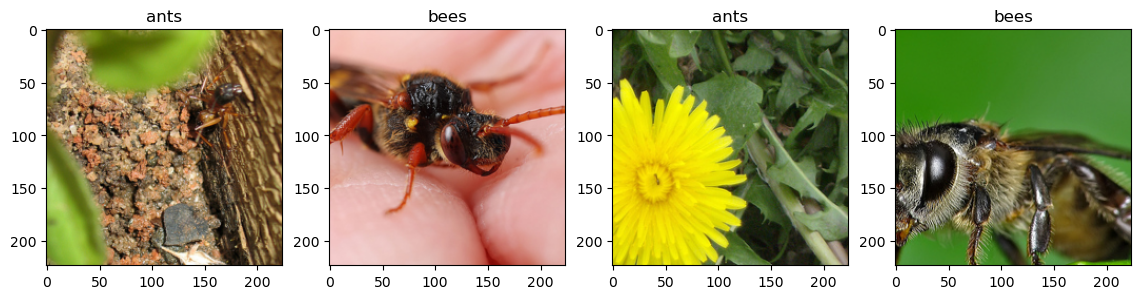

In [49]:
plt.figure(figsize=(14,5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i].movedim(0,-1)*std[0]+mean[0])
    plt.title(CLASSES[labels[i]])

## Training function

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Loading ResNet

In [51]:
model = torchvision.models.resnet18(pretrained=True)
torchsummary.summary(model, (3, 224, 224), device=torch.device("cpu"))

c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

(tensor(11689512), tensor(11689512))

### Change the last layer

In [52]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)

### Train entire model (All layers)

StepLR Decays the learning rate of each parameter group by gamma every step_size epochs

Decay LR by a factor of 0.1 every 7 epochs

Learning rate scheduling should be applied after optimizer’s update

e.g., you should write your code this way:

for epoch in range(100):

    - train(...)
    - validate(...)
    - scheduler.step()

In [53]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [54]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.6133 Acc: 0.6393
val Loss: 0.4575 Acc: 0.8105

Epoch 1/1
----------
train Loss: 0.5081 Acc: 0.7418
val Loss: 0.3498 Acc: 0.8824

Training complete in 2m 16s
Best val Acc: 0.882353


### Train only last layer

Set "requires_grad" to False on all loaded layers

In [55]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

Parameters of newly constructed modules have requires_grad=True by default

In [57]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 2)

In [61]:
criterion = torch.nn.CrossEntropyLoss()

# Only FC Layer parameters need to be updated
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Observe that only parameters of final layer are being optimized as opposed to before.

In [62]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5072 Acc: 0.7541
val Loss: 0.2503 Acc: 0.9085

Epoch 1/1
----------
train Loss: 0.4740 Acc: 0.8074
val Loss: 0.3372 Acc: 0.8627

Training complete in 1m 8s
Best val Acc: 0.908497
